In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load datasets
resale_flats = pd.read_csv('ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')
rent_flats = pd.read_csv('RentingOutofFlatsfromJan2021.csv')
print(resale_flats.head())
print(rent_flats.head())
#some data that are present in 1 dataset are not present in the other
#namely story_range, floor area, flat model, lease remaining


     month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      265000.

In [7]:
#preprocessing
#Convert month and rent_approval_date to datetime
resale_flats['month'] = pd.to_datetime(resale_flats['month'], format='%Y-%m')
rent_flats['rent_approval_date'] = pd.to_datetime(rent_flats['rent_approval_date'], format='%Y-%m')
resale_flats['lease_commence_date'] = pd.to_datetime(resale_flats['lease_commence_date'], format='%Y')
print(resale_flats.head())
print(rent_flats.head())

#Using towns as common key for clustering
resale_towns = resale_flats['town'].unique()
rent_towns = rent_flats['town'].unique()

# print(resale_towns)
# print(rent_towns)
#resale has Central Area which is not present in resale_towns (central) 
#So we will replace Central Area with Central in resale_flats
resale_flats['town'] = resale_flats['town'].str.strip() #remove leading/trailing spaces
resale_flats['town'] = resale_flats['town'].str.upper() #convert to uppercase for uniformity
rent_flats['town'] = rent_flats['town'].str.strip()
rent_flats['town'] = rent_flats['town'].str.upper()
resale_flats['town'] = resale_flats['town'].replace('CENTRAL AREA', 'CENTRAL')
#resale_towns does not have TENGAH but rent_towns has TENGAH
#we will not use tengah in our analysis as a result (total 25 towns)
common_towns = set(resale_towns).intersection(set(rent_towns))
print(common_towns)
print(len(common_towns))
#drop rows with towns not in common_towns, these will be used as a direct comparison
resale_flats_clean = resale_flats[resale_flats['town'].isin(common_towns)] 
rent_flats_clean = rent_flats[rent_flats['town'].isin(common_towns)]



       month        town flat_type block        street_name storey_range  \
0 2017-01-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1 2017-01-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2 2017-01-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3 2017-01-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4 2017-01-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model lease_commence_date     remaining_lease  \
0            44.0        Improved          1979-01-01  61 years 04 months   
1            67.0  New Generation          1978-01-01  60 years 07 months   
2            67.0  New Generation          1980-01-01  62 years 05 months   
3            68.0  New Generation          1980-01-01   62 years 01 month   
4            67.0  New Generation          1980-01-01  62 years 05 months   

   resale_price  
0      232000.0  
1      250000.0  
2      262000.0  
3      2

         town      month   resale_price rent_approval_date  monthly_rent  \
0  ANG MO KIO 2021-01-01  435967.688172         2021-01-01   1944.193548   
1  ANG MO KIO 2021-02-01  409739.466667         2021-02-01   1926.308725   
2  ANG MO KIO 2021-03-01  415006.711111         2021-03-01   1951.704225   
3  ANG MO KIO 2021-04-01  424223.348837         2021-04-01   1921.738854   
4  ANG MO KIO 2021-05-01  457865.217949         2021-05-01   1953.116279   

   price_rent_ratio  
0         18.686741  
1         17.725588  
2         17.719843  
3         18.395812  
4         19.535670  


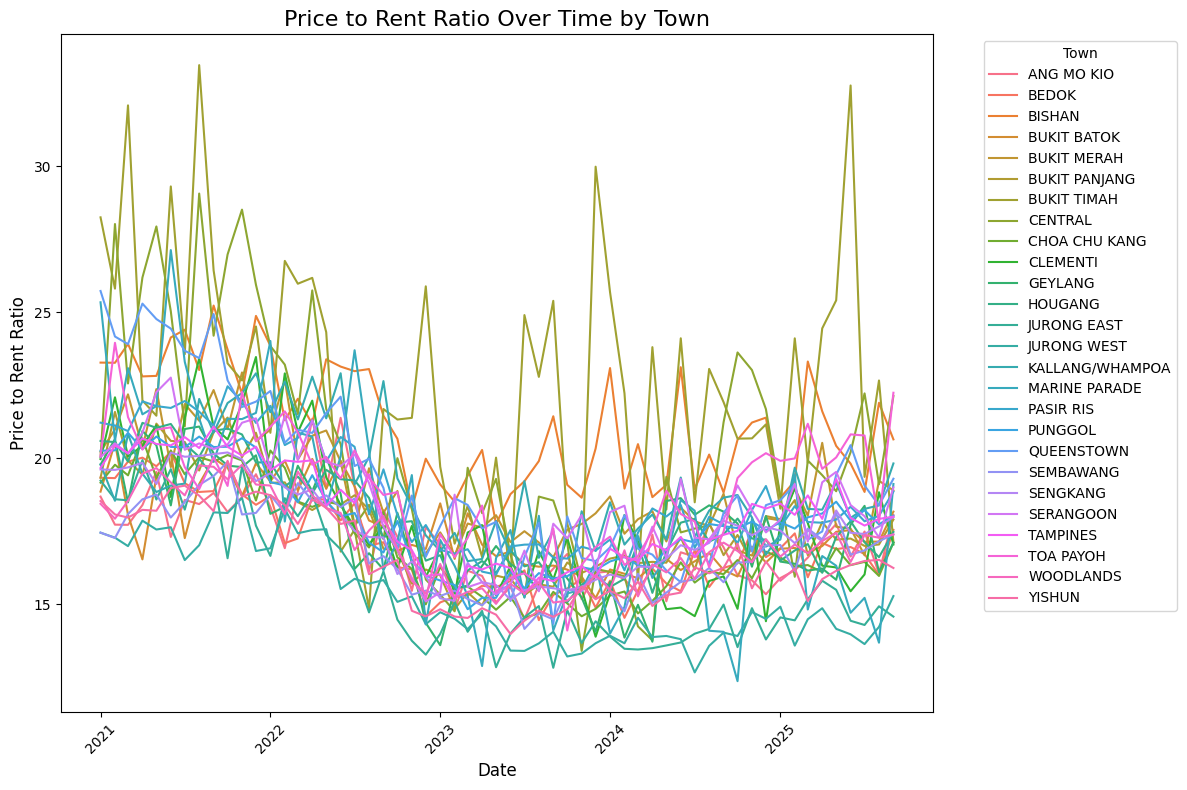

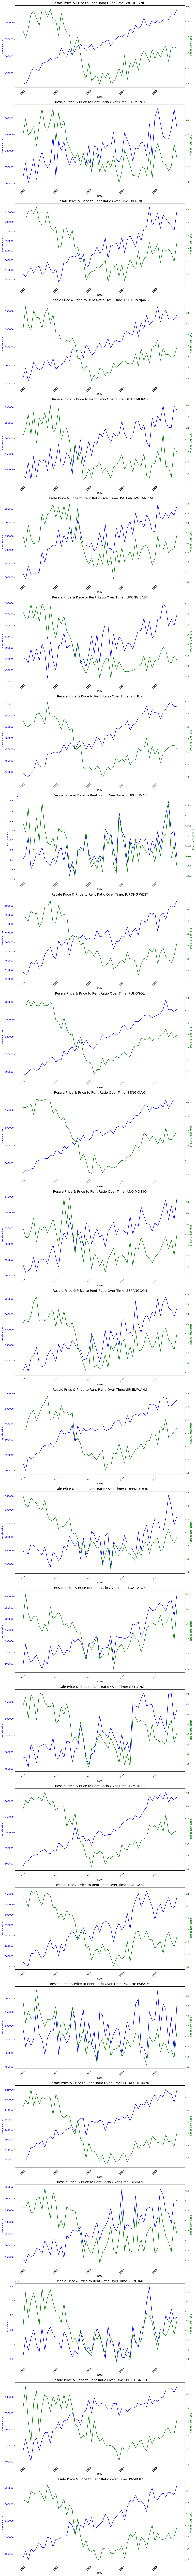

In [8]:
#Find average resale price and rent price per town for each year
average_resale_prices = resale_flats_clean.groupby(['town', 'month'])['resale_price'].mean().reset_index()
average_rent_prices = rent_flats_clean.groupby(['town', 'rent_approval_date'])['monthly_rent'].mean().reset_index()
#print(average_resale_prices.head())
#print(average_rent_prices.head())
price_rent_ratio = pd.merge(average_resale_prices, average_rent_prices, left_on=['town', 'month'], right_on=['town', 'rent_approval_date'], how='inner')
#print(price_rent_ratio.head())
price_rent_ratio['price_rent_ratio'] = price_rent_ratio['resale_price'] / (price_rent_ratio['monthly_rent'] * 12)
print(price_rent_ratio.head())
#Visualize the price to rent ratio over time for each town
# Set the 'date' as the index for time series plotting (optional, but useful)
price_rent_ratio.set_index('month', inplace=True)

# Create the plot
plt.figure(figsize=(12, 8))

# Use seaborn to create a line plot for each town
sns.lineplot(data=price_rent_ratio, x='month', y='price_rent_ratio', hue='town')

# Customize the plot
plt.title('Price to Rent Ratio Over Time by Town', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price to Rent Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Town', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


# Create a figure and a grid of subplots (one per town)
fig, axes = plt.subplots(len(common_towns), 1, figsize=(12, 6 * len(common_towns)))

# If there's only one town, 'axes' will be a single Axes object instead of an array
if len(common_towns) == 1:
    axes = [axes]
# Loop through each town and plot its data in the respective subplot
for i, town in enumerate(common_towns):
    town_data = price_rent_ratio[price_rent_ratio['town'] == town]
    # sns.lineplot(data=town_data, x='month', y='price_rent_ratio', ax=axes[i])
    # axes[i].set_title(f'Price to Rent Ratio Over Time: {town}', fontsize=16)
    # axes[i].set_xlabel('Date', fontsize=12)
    # axes[i].set_ylabel('Price to Rent Ratio', fontsize=12)
    # axes[i].tick_params(axis='x', rotation=45)
    # sns.lineplot(data=town_data, x='month', y='resale_price', ax=axes[i])
    # axes[i].set_title(f'Resale Price Over Time: {town}', fontsize=16)
    # axes[i].set_xlabel('Date', fontsize=12)
    # axes[i].set_ylabel('Resale Price', fontsize=12)
    # axes[i].tick_params(axis='x', rotation=45)
        # Plot price_to_rent_ratio
    # Plot resale_price on the first y-axis
    ax1 = axes[i]
    sns.lineplot(data=town_data, x='month', y='resale_price', ax=ax1, color='blue')
    ax1.set_title(f'Resale Price & Price to Rent Ratio Over Time: {town}', fontsize=14)
    ax1.set_xlabel('Date', fontsize=10)
    ax1.set_ylabel('Resale Price', fontsize=10, color='blue')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis (for price_to_rent_ratio)
    ax2 = ax1.twinx()
    sns.lineplot(data=town_data, x='month', y='price_rent_ratio', ax=ax2, color='green')
    ax2.set_ylabel('Price to Rent Ratio', fontsize=10, color='green')
    ax2.tick_params(axis='y', labelcolor='green')

# Adjust layout so everything fits
plt.tight_layout()

# Show the plot
plt.show()
